In [1]:
from math import *
import numpy as np
from triqs.gf import *
from triqs.operators import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import plt,oplot
%matplotlib inline


In [4]:
plt.rcParams.update({'font.size': 15})

Ut= 12
nloops= 39


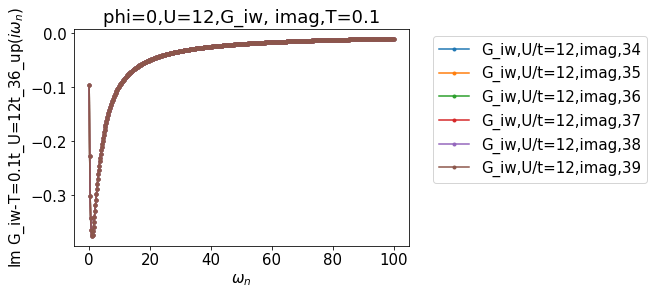

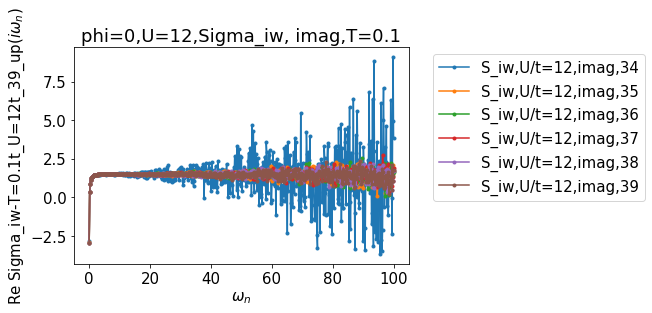

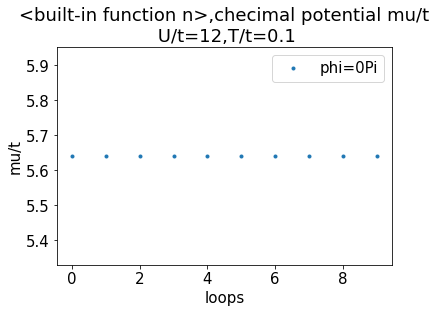

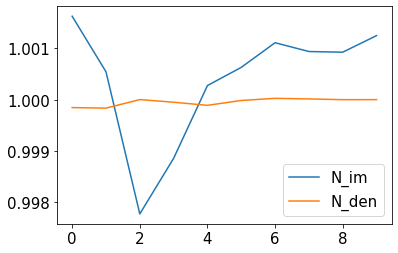

In [7]:
# check different functions to see whether the calculation converges
phi=0
Ut=12
files=[f"para_data/check_phi={np.around(phi/pi,3)}_Ut={Ut}.h5"]

t=0.25


for filename in files:
    Ut=int(filename.split("Ut=")[1].split(".")[0])
    print("Ut=", Ut)
    with HDFArchive(filename,'r') as A:
        n_loops=A['iterations']
        print("nloops=", n_loops)
    for Temp in [0.1]:
        #check green function at final iterations

        with HDFArchive(filename,'r') as A:
            for iteration in range(n_loops-5,n_loops+1):
                oplot(A['G_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-3)]['up'].imag,'.-',label=f"G_iw,U/t={Ut},imag,{iteration}",x_window  = (0, 100))

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"phi={phi},U={Ut},G_iw, imag,T={Temp}")
        plt.show()


        #check self energy at final iterations
        with HDFArchive(filename,'r') as A:
            for iteration in range(n_loops-5,n_loops+1):
                oplot(A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,iteration)]['up'].real,'.-',label=f"S_iw,U/t={Ut},imag,{iteration}",x_window  = (0, 100))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"phi={phi},U={Ut},Sigma_iw, imag,T={Temp}")
        plt.show()
        
        #check chemical potential
        with HDFArchive(filename,'r') as A:
            mulist=[]
            N_denlist=[]
            Nim_list=[]
            for it in range(30,n_loops+1):
                mulist.append(A['mu-T=%st_U=%st_%i'%(Temp,Ut,it)])
                N_denlist.append(A['N_den-T=%st_U=%st_%i'%(Temp,Ut,it)])
                Nim_list.append(A['Nim-T=%st_U=%st_%i'%(Temp,Ut,it)])    
            plt.plot(np.array(mulist)/t,".",label=f"phi={phi}Pi")
            plt.title(f"{n},checimal potential mu/t\n U/t={Ut},T/t={Temp}")
            plt.xlabel("loops")
            plt.ylabel("mu/t")
            plt.legend()
            plt.show()
            #plt.savefig(f'fig/mu_U={Ut}_T={Temp}.png',dpi=600, bbox_inches='tight')
            plt.plot(Nim_list,label="N_im")
            plt.plot(N_denlist,label="N_den")
            #plt.ylim(0.95,1.05)
            plt.legend()
            plt.show()

In [8]:
#fit the tail of self energy
def fit_tail(S_iw, nmin, nmax, order = 4, known_moments= [], block = 'up_0', orb=0, xlim=(0,40), ylim=(-1.5,0.1)):

    beta =S_iw[block].mesh.beta

    mesh = np.array([w.imag for w in S_iw[block].mesh])

    S_iw_mfit = S_iw.copy()
    print(known_moments)

#     if not known_moments:
#         shape = [0] + list(S_iw_mfit['up'].target_shape)

#         known_moments = np.zeros(shape, dtype=np.complex)
#         print("test",known_moments)

    o_min = (2*nmin+1)*np.pi/beta

    o_max = (2*nmax+1)*np.pi/beta
    for block, Gf_bl in S_iw_mfit:
        tail, err = S_iw_mfit[block].fit_hermitian_tail_on_window(n_min = nmin,
                                                      n_max = nmax ,
                                                      known_moments = known_moments,
                                                      n_tail_max = 2 * len(S_iw_mfit.mesh) ,
                                                      expansion_order = order)

        S_iw_mfit[block].replace_by_tail(tail,nmax)


        S_iw_mfit[block].replace_by_tail(tail,nmax)

    fig, (ax1) = plt.subplots(1,1,figsize=(10,6))

    ax1.axvline(x=o_min, color='k',label='window')
    ax1.axvline(x=o_max, color='k')

    ax1.plot(mesh,S_iw['up'][orb,orb].data.imag,'o',lw=3,label='raw',markersize=4)
    ax1.plot(mesh,S_iw_mfit['up'][orb,orb].data.imag,'-',lw=3,label='fit')

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_ylabel(r"$Im \Sigma (i \omega)$")
    ax1.set_xlabel(r"$\omega$")

    ax1.legend(loc='lower right', ncol=1,numpoints=1,handlelength=1,fancybox=True,
               labelspacing=0.2,borderaxespad=0.5,borderpad=0.35,handletextpad=0.4)

    plt.show()

    return S_iw_mfit

Ut= 12
nloops= 39
1.4101549032329044
[[[1.5+0.j]]]


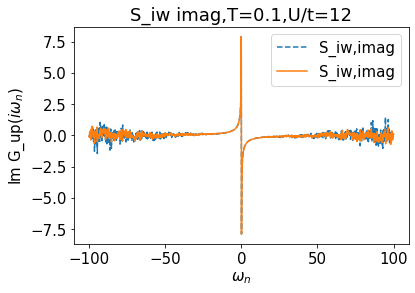

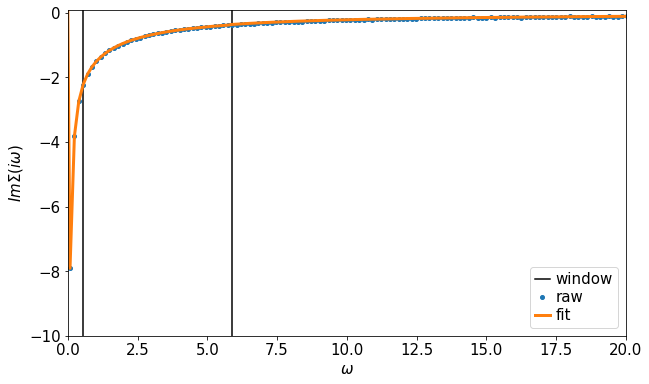

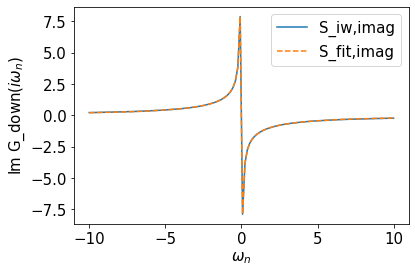

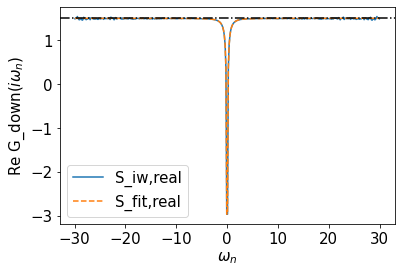

In [17]:
phi=0

for Ut in [12]:
    n_dope=1

    filename=f"para_data/check_phi={np.around(phi/pi,3)}_Ut={Ut}.h5"
    print("Ut=", Ut)
    Sfinlist=[]
    with HDFArchive(filename,'r') as A:
        n_loops=39#A['iterations']
        print("nloops=", n_loops)
    for Temp in [0.1]:
        
        with HDFArchive(filename,'r') as A:
            # take the average of the last 5 dmft results to do the tail fitting
            
            n_average=5   
            G_tau = A['G_tau-T=%st_U=%st_%i'%(Temp,Ut,n_loops)]
            G_iw = A['G_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops)]
            sigma=A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops)]/n_average
            for i in range(n_average-1):
                sigma+=A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i-1)]/n_average
                G_iw+=A['G_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i-1)]/n_average
                G_tau+= A['G_tau-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i-1)]/n_average

            oplot(A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-1)]['up'].imag,'--',label=f"S_iw,imag",x_window  = (-100,100))   
            oplot(sigma['up'].imag,'-',label=f"S_iw,imag",x_window  = (-100,100))
            Sigma_iw= sigma
            G=A['G_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops)]
            mu=A['mu-T=%st_U=%st_%i'%(Temp,Ut,n_loops)] 
            print(mu)
            plt.legend()
            plt.title(f"S_iw imag,T={Temp},U/t={Ut}")
            #fit the tail

            beta =Sigma_iw['up'].mesh.beta
            if Temp<=0.6:
                nmin=3 #int((2*beta/np.pi-1)/2)#3
                nmax=int((6*beta/np.pi-1)/2)

            elif Temp<=2:
                nmin=0
                nmax=int((20*beta/np.pi-1)/2)
            else:
                nmin=0
                nmax=6
            shape = [1] + list(Sigma_iw['up'].target_shape)
            known_moments = np.zeros(shape, dtype=np.complex128)
            known_moments[0,0,0]=Ut*t/2*n_dope
            #known_moments[1,0,0]=Ut*t/2*n_dope*n_dope*(1-n_dope/2)
            S_fit=fit_tail(Sigma_iw, nmin, nmax, order = 10, known_moments= known_moments, block = 'up', orb=0, xlim=(0,20), ylim=(-10,0.1))
            ## show the result
            oplot(Sigma_iw['down'].imag,'-',label=f"S_iw,imag",x_window  = (-10,10))
            oplot(S_fit['down'].imag,'--',label=f"S_fit,imag",x_window  = (-10,10))
            plt.legend()
            plt.show()
            oplot(Sigma_iw['down'].real,'-',label=f"S_iw,real",x_window  = (-30,30))
            oplot(S_fit['down'].real,'--',label=f"S_fit,real",x_window  = (-30,30))
            plt.axhline(y=Ut*t/2*n_dope,linestyle="-.",color="black")
            plt.legend()
            plt.show()
            Sfinlist.append(S_fit['up'](1000).real[0][0])
#             with HDFArchive("para_data/checkfit_tri_phi=%s_n=%s.h5"%(np.around(phi/pi,3),n_dope)) as A:
#                 A['S_fit_iw-T=%st_U=%st'%(Temp,Ut)] = S_fit
#                 A['Sigma_iw-T=%st_U=%st'%(Temp,Ut)] =Sigma_iw
#                 A['mu-T=%st_U=%st'%(Temp,Ut)]=mu
#                 A['G_tau-T=%st_U=%st'%(Temp,Ut)]=G_tau
#                 #A['G_tau2-T=%st_U=%st'%(Temp,Ut)]=G_tau2
#                 A['G_iw-T=%st_U=%st'%(Temp,Ut)]=G_iw




